# Introduction
 
In this notebook, we show how Mercury can help us to detect drift in datasets.

In general, drift refers to a change in the data due to a change in the conditions that generate the data. This is important to detect because it can cause degradation or invalidate a previously trained model:

![Drift Example](../images/drift_example.png)


Here we consider two different scenarios:
- Scenario 1: We have access to the training dataset.
- Scenario 2: We do not have access to the training dataset, but we have access to the distributions of the features used in training.

To illustrate how we can detect drift in real cases, we introduce drift in a dataset and then we use Mercury to detect it. We split the notebook into the next sections.

#### [1. Load dataset and experiment setup](#load_dataset)
#### [2. Train Model with data available at time 0](#train_model)
#### [3. Generate histograms for training data](#generate_histograms)
#### [4. Inference](#inference)
#### [5. Drift Detection - Scenario 1: Initial Training Dataset available](#scenario_1)
#### [6. Drift Detection - Scenario 2: Only histograms/distributions are available](#scenario_2)
#### [7. Drift Detection - Model predictions](#drift_predictions)
#### [8. Drift  Evolution over time](#drift_evolution)


In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed=2021)

<a id="load_dataset"></a>
## 1. Load dataset and setup experiment

We use the wine quality dataset [[1]](#[1]) dataset. The files of this dataset are available inside of the /data/winequality folder in tutorials and it is also available in the [UCI ML repository](https://archive.ics.uci.edu/ml/datasets/wine+quality) 

Each row of the dataset represents a different wine and it contains attributes like the acidity of the wine or the level of alcohol. The dataset also contains the quality of the wine, ranging from 0 to 10. 

In [2]:
df_red_wines = pd.read_csv("../data/winequality/winequality-red.csv")
df_white_wines = pd.read_csv("../data/winequality/winequality-white.csv")

df_red_wines["type"] = "red"
df_white_wines["type"] = "white"

df = pd.concat([df_red_wines, df_white_wines])

### Experiment Setup

We convert this quality to an integer to indicate if it is a high-quality wine or not. We suppose that we have the goal of building a model to predict if a wine will be a high-quality wine given its attributes.


Importantly, to illustrate the drift functionalities and simulate a real situation we introduce a time column. This column represents the time when that wine is available. The important considerations to understand the setup are the next:
- The wines where time is equal to 0 represent the wines available for training a model. ALL these wines have a level of alcohol lower (or equal) than 11.
- We introduce new wines at each timestep. Different from the training set, these new wines can have a level of alcohol higher than 11. For each timestep, we proportion of wines with a higher level of alcohol than 11 grows. The total number of timesteps is 7.

In [3]:
# Create id
df["id"] = np.arange(df.shape[0])

# Encode Label
df["quality"] = df["quality"].apply(lambda x: 1 if x >=7 else 0)

# Encode Type
le = preprocessing.LabelEncoder()
df["type"] = le.fit_transform(df["type"])

# Set attribute to indicate high alcohol
df["high_alcohol"] = df["alcohol"].apply(lambda x: True if x > 11 else False)

# Time will represent the moment we have that data
df["time"] = -1

# For those rows with high alcohol, we set 70% of them as time 0 (they will be used as training)
df["time"] = df.apply(
    lambda x: 0 if (x["high_alcohol"] == False) and (np.random.uniform() < 0.7) else -1, axis=1
 )

# Each timestep, new amount of samples low_alcohol and high_alcohol
n_samples_low_alcohol = [250, 245, 230, 210, 180, 140, 30]
n_samples_high_alcohol = [0, 5, 10, 20, 40, 80, 160]
max_timesteps = 7
for t in range(1, max_timesteps + 1):
    # Sample examples with high_alcohol == True
    n_samples = n_samples_high_alcohol[t-1]
    sampled_ids = df[(df["time"] == -1) & (df["high_alcohol"] == True)].sample(
        n_samples, random_state=2021)["id"].values
    df.loc[df["id"].isin(sampled_ids), "time"] = t
    # Sample examples with high_alcohol == False
    n_samples = n_samples_low_alcohol[t-1]
    sampled_ids = df[(df["time"] == -1) & (df["high_alcohol"] == False)].sample(
        n_samples, random_state=2021)["id"].values
    df.loc[df["id"].isin(sampled_ids), "time"] = t 

The next figure shows how the number of wines with low alcohol level decreases over time, while the number of wines with a high level of alcohol increases:

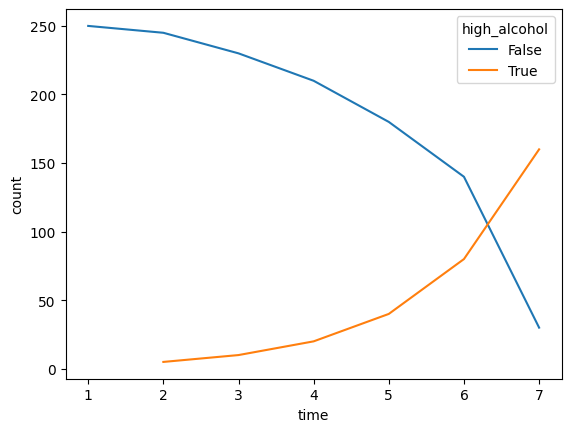

In [4]:
sample_counts = df.groupby(["time", "high_alcohol"])["id"].count().to_frame().reset_index()
sample_counts = sample_counts.rename(columns={"id": "count"})
sample_counts = sample_counts[sample_counts["time"] > 0]
ax = sns.lineplot(x="time", y="count", hue="high_alcohol", data=sample_counts)

<a id="train_model"></a>
# 2. Train Model with data available at timestep 0

The initial dataset is the dataset with the wines at time 0. It represents the data available initially that we can use for training

In [5]:
df_initial = df[df["time"] == 0]

We split initial dataset between train/test:

In [6]:
from sklearn.model_selection import train_test_split

label = 'quality'
features = [c for c in df.columns if c not in [label, 'time', 'high_alcohol', 'id']]

X_initial = df_initial[features].values
y_initial = df_initial[label].values

X_train, X_test, y_train, y_test = train_test_split(X_initial, y_initial, test_size=0.3, random_state=42)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)
print("y_train: ", y_train.shape)
print("y_test: ", y_test.shape)

X_train:  (2184, 12)
X_test:  (937, 12)
y_train:  (2184,)
y_test:  (937,)


We train a Random Forest Classifier:

In [7]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=30, max_depth=4)
model = model.fit(X_train, y_train)

<a id="generate_histograms"></a>
# 3. Generate histograms for training data

As we mentioned at the beginning of the notebook we consider two scenarios. In scenario 2, we anticipate that the original training data samples won't be available later for drift detection, so we need to obtain the histograms as a representation of our training data. We will use these histograms in scenario 2 where we don't have access to the training data samples.

We can create the histograms in multiple ways. Here we provide a class that can help to create these histograms for the training data. Later, we will use the created object to calculate the histograms in posterior timesteps.

In [8]:
from sklearn.preprocessing import KBinsDiscretizer

class HistogramGenerator():
    
    def __init__(self, n_bins=10, encode='ordinal', strategy='uniform'):
        self.n_bins = n_bins
        self.encode = encode
        self.strategy = strategy
    
    def fit(self, X):
        self.bin_discretizer = KBinsDiscretizer(n_bins=self.n_bins, encode=self.encode, strategy=self.strategy)
        self.bin_discretizer = self.bin_discretizer.fit(X)
        self.num_bins = [len(bin_edges)-1 for bin_edges in self.bin_discretizer.bin_edges_]
        return self

    def get_histograms(self, X):

        X_bins = self.bin_discretizer.transform(X)
        bin_counts = []
        for idx in range(X_bins.shape[1]):
            unique, counts = np.unique(X_bins[:,idx], return_counts=True)
            counts_feature = []
            for i in range(self.num_bins[idx]):
                if i in unique:
                    counts_feature.append(counts[list(unique).index(i)])
                else:
                    counts_feature.append(0)
            bin_counts.append(np.array(counts_feature))
        return bin_counts

histogram_generator = HistogramGenerator(n_bins=10)
histogram_generator = histogram_generator.fit(X_train)
histograms_train = histogram_generator.get_histograms(X_train)


<a id="inference"></a>
# 4. Inference

Now we use this model for inference. Let's generate the predictions for all the subsequent timesteps. This would happen gradually if we use this model in production.

In [9]:
df_new = df[df["time"] >= 0].copy()
X_new = df_new[features].values
y_new = df_new[label].values

print("X_new: ", X_new.shape)
print("y_new: ", y_new.shape)

df_new["pred_prob"] = model.predict_proba(X_new)[:,1]

X_new:  (4721, 12)
y_new:  (4721,)


In [10]:
df_new.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type,id,high_alcohol,time,pred_prob
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,0,0,False,0,0.030031
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,0,1,False,4,0.017478
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,0,2,False,0,0.017478
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,0,3,False,0,0.055077
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,0,4,False,1,0.030031


<a id="scenario_1"></a>
# 5. Drift Detection - Scenario 1: Initial Training Dataset available

The first scenario that we consider is when we have the initial training dataset available. In this case, we can use the drift methods that use the dataset samples to detect drift. The available methods in mercury are:

- DomainClassifierDrift  
- KSDrift

Although all the methods calculate drift differently and some have extra functionalities, all of them have something in common: they return a dictionary when calling the `calculate_drift()` method with at least the next two keys:
- `score`: a drift score that indicates the amount of drift in a dataset. The meaning of the score is different in each method so scores from different methods cannot be compared, but scores from the same method can be used to track the amount of drift at different timesteps.
- `drift_detection`: boolean indicating if drift is detected or not.

We will explore if drift is detected in using these two methods in two different timesteps: Timestep 1 and Timestep 6. We start obtaining:

- `X_src` as the initial dataset used in training  
- `X_t1` the new data obtained at timestep 1
- `X_t6` the new data obtained at timestep 6

In [11]:
X_src = X_initial.copy()
X_t1 = df[df["time"] == 1][features].values.copy()
X_t6 = df[df["time"] == 6][features].values.copy()
print(X_src.shape)
print(X_t1.shape)
print(X_t6.shape)

(3121, 12)
(250, 12)
(220, 12)


### DomainClassifierDrift 

The class `DomainClassifierDrift` allows us to train a classifier (Random Forest) to distinguish between a source dataset (the one used in training in this case) and a target dataset (the data used in inference in this case).

The drift score returned represents the AUC metric of the classifier. The higher the score, the higher the capacity of the model to distinguish between source and target datasets. A score around 0.5 means that the classifier is not able to distinguish.

Now, Let's calculate the drift at timestep 1:

In [12]:
from mercury.monitoring.drift.domain_classifier_drift_detector import DomainClassifierDrift

domain_class_drift = DomainClassifierDrift(X_src, X_t1, features=features, p_val=0.01, test_size=0.3, n_runs=10)
drift_metrics = domain_class_drift.calculate_drift()

print("Drift Score: ", drift_metrics["score"])
print("p_val: ", drift_metrics["p_val"])
print("Is drift detected? ", drift_metrics["drift_detected"])

Drift Score:  0.5009626467449306
p_val:  0.9990234375
Is drift detected?  False


We see that the drift score (AUC) is close to 0.5. That means, that the domain classifier is not able to distinguish between samples  from the initial dataset and samples obtained at timestep 1. The p-value measure is quite high, which confirms that the Domain Classifier doesn't detect drift in this case.

Now, let's see at timestep 6:

In [13]:
from mercury.monitoring.drift.domain_classifier_drift_detector import DomainClassifierDrift

domain_class_drift = DomainClassifierDrift(X_src, X_t6, features=features, p_val=0.05, test_size=0.3, n_runs=10)
drift_metrics, df_drift_scores = domain_class_drift.calculate_drift(return_drift_score_target=True)

print("Drift score: ", drift_metrics["score"])
print("p-value: ", drift_metrics["p_val"])
print("Is drift detected? ", drift_metrics["drift_detected"])

Drift score:  0.6922964975259533
p-value:  0.0009765625
Is drift detected?  True


We see now the AUC is much higher. The p-value is also lower now, enough to make the DomainClassifierDrift conclude that there is drift. 

<b> Which feature is causing the drift? </b>

When we calculated the drift with the domain classifier, we can use the method `plot_feature_drift_scores` to see the feature importance of the classifier trained to discriminate between source and target dataset. That can help us to identify which features are causing the drift. In this case, we see that alcohol is the feature with  more importance, which makes sense with the setup of the experiment:

<AxesSubplot:title={'center':'feature drift scores'}>

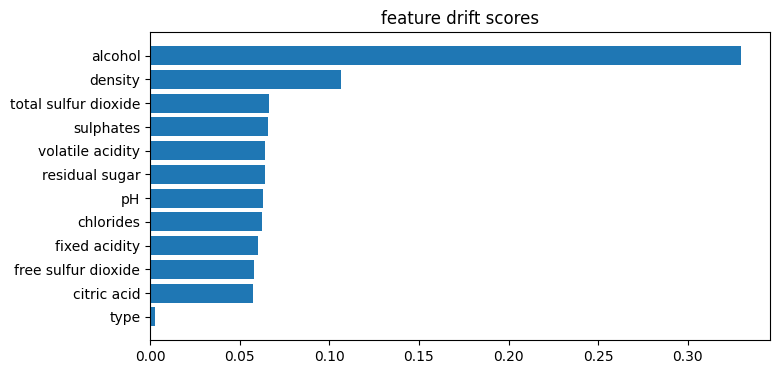

In [14]:
domain_class_drift.plot_feature_drift_scores(figsize=(8,4))

The drift detector also has a method to visualize the distributions of source and target datasets for a particular feature. If we look at the feature "alcohol", we can observe that indeed there is drift in the distribution:

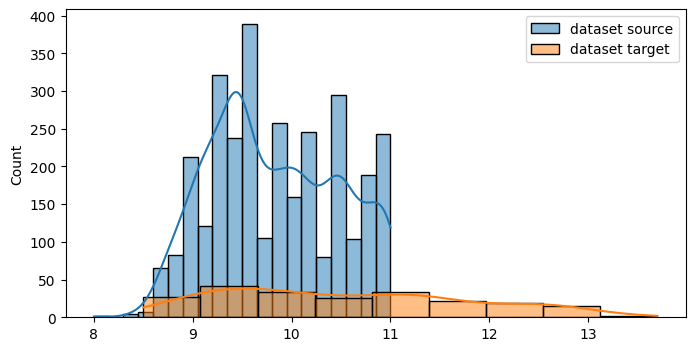

In [15]:
ax = domain_class_drift.plot_distribution_feature(name_feature="alcohol")

<b> Which are the drifted samples? </b>

The domain classifier has an extra functionality that can help us to retrieve the target data samples that are causing the drift. We calling `calculate_drift` method we can set the parameter `return_drift_score_target` to `True`. That computes a drift score for each sample in the target dataset (which is the predicted probability by the domain classifier). In this case, we recovered these scores and stored them in the dataframe `df_drift_scores`. If we look at these examples we see that those wines with higher alcohol level have higher drift score:


<AxesSubplot:xlabel='alcohol', ylabel='drift_score'>

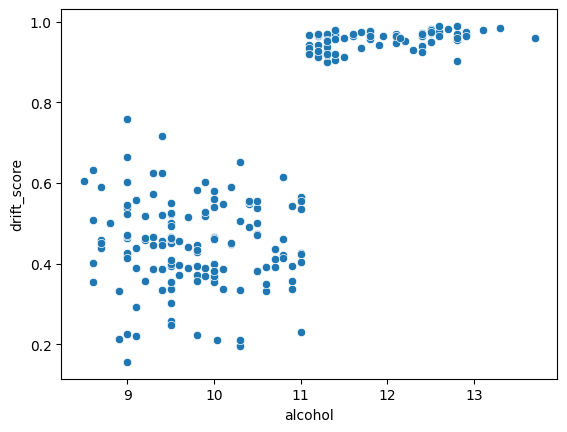

In [16]:
sns.scatterplot(x="alcohol", y="drift_score", data=df_drift_scores)

### KS Drift 

The class `KSDrift` calculates the drift by calculating the Kolmogorov-Smirnov statistic on 2 samples for each feature independently. This tests whether 2 samples are drawn from the same distribution. The method performs a KS test individually for each feature and then compares if in any of the features the p-value is lower than the provided p-value as a threshold. If we specify the `correction` parameter as "bonferroni" then a correction is applied to take into account that multiple tests are applied. Specifying the Bonferroni correction or selecting a lower p-value makes the test more conservative.

In this case, the method `calculate_drift` returns the dictionary with the next metrics:
- p_vals: all the p-values returned by the KS test for each feature.
- scores: all the KS statistic values returned by the KS test for each feature.
- score: average of all the KS statistic scores.
- drift_detected: boolean indicating the decision if drift is detected. It depends on the selected p-value and the correction.
- threshold: the final threshold (to compare the p-values) applied after the correction is applied.


Now, let's repeat the drift calculation with the KSDrift. We start calculating the drift at timestep 1.

In [17]:
from mercury.monitoring.drift.ks_drift_detector import KSDrift

ks_drift = KSDrift(X_src, X_t1, features=features, p_val=0.01, correction="bonferroni")
drift_metrics = ks_drift.calculate_drift()

print("Drift score: ", drift_metrics["score"])
print("Is drift detected?: ", drift_metrics["drift_detected"])

Drift score:  0.04837616
Is drift detected?:  False


We can see that drift is not detected in this case. If we look at the returned dictionary we can see the metrics for each feature:

In [18]:
drift_metrics

{'p_vals': array([0.35122484, 0.81449556, 0.99869657, 0.11887604, 0.18616427,
        0.51921195, 0.32436976, 0.8969964 , 0.61289823, 0.75644153,
        0.9649746 , 0.9855496 ], dtype=float32),
 'scores': array([0.06055111, 0.04110093, 0.02435245, 0.07743031, 0.07095162,
        0.05294842, 0.06195963, 0.0370612 , 0.04920346, 0.04354886,
        0.03210638, 0.02929958], dtype=float32),
 'score': 0.04837616,
 'drift_detected': False,
 'threshold': 0.0008333333333333334}

Now, let's see the drift in timestamp 6:

In [19]:
from mercury.monitoring.drift.ks_drift_detector import KSDrift

ks_drift = KSDrift(X_src, X_t6, features=features, p_val=0.01, correction="bonferroni")
drift_metrics = ks_drift.calculate_drift()

print("Drift score: ", drift_metrics["score"])
print("Is drift detected?: ", drift_metrics["drift_detected"])

Drift score:  0.1018239
Is drift detected?:  True


We see that the score is higher now and drift has been detected.

We also have available now the method `plot_feature_drift_scores`. In this case, it shows the KS statistic value obtained for each feature

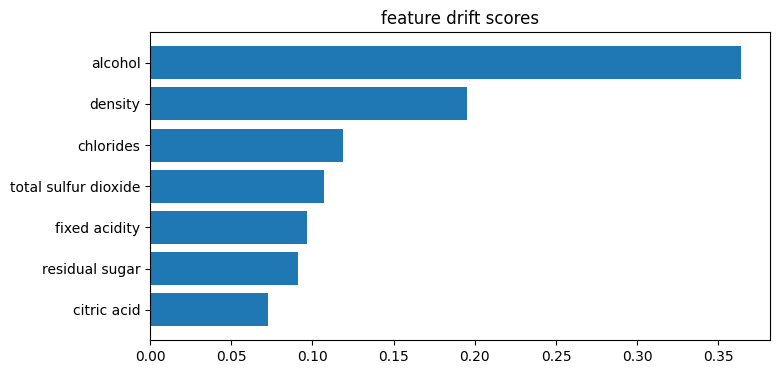

In [20]:
ax = ks_drift.plot_feature_drift_scores(top_k=7)

We can also use the method `get_drifted_features` which returns which features are causing the drift by using the p-values. This method is available in all drift methods that calculate a different p-value for each feature:

In [21]:
print(ks_drift.get_drifted_features())
print(ks_drift.get_drifted_features(return_as_indices=True))

['density', 'alcohol']
[7, 10]


Finally, the method `plot_distribution_drift_features` allows us to quickly plot the distribution of the features that are considered to produce drift:

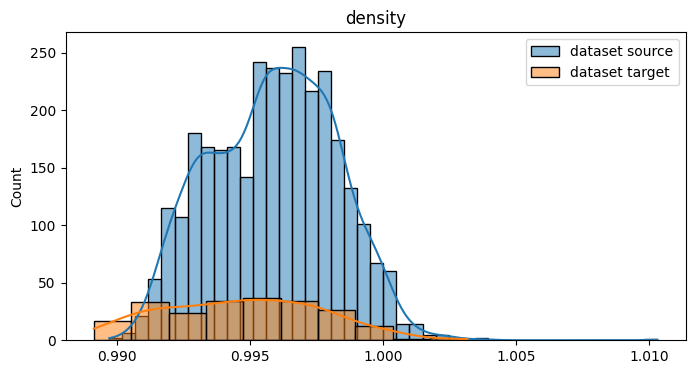

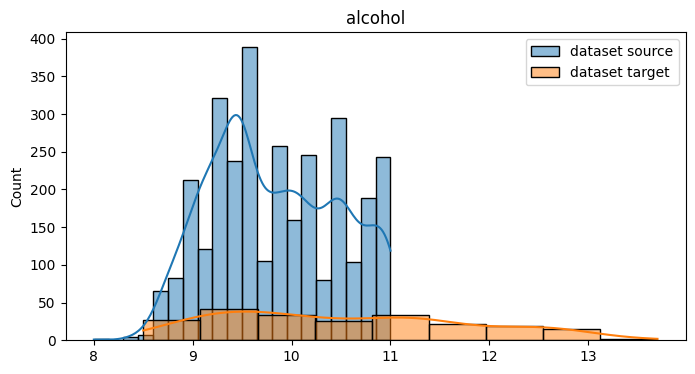

In [22]:
ks_drift.plot_distribution_drifted_features()

<a id="scenario_2"></a>
# 6. Drift Detection - Scenario 2: Only histograms/distributions are available

Sometimes, we don't have access to the data samples used for training. In those cases, we can store the distributions (histograms) of the dataset used in training and compare them with the histograms of the data used in inference. For that, we have the next available methods:

- HistogramDistanceDrift
- Chi2Drift

As in the previous section, we will analyze the drift in timesteps 1 and 6.

In section 2, we created the histograms for the training set. Now, we need to create the histograms for timesteps 1 and 6. As before, the histograms are represented in a list of arrays, where each array represents the histogram of one variable. The values of the array represent the counts of each bin. It is <b>very important</b> that the bin edges of the histograms generated in inference correspond to the same bins of the histogram generated in training, and that the order of the variables represented in the list are the same in both cases.

In [23]:
histograms_t1 = histogram_generator.get_histograms(X_t1)
histograms_t6 = histogram_generator.get_histograms(X_t6)

### HistogramDistanceDrift

The HistogramDistanceDrift class computes the drift by calculating the distance of two histograms. The distance functions available are the Hellinger distance and the Jeffreys divergence. We specify the distance function when creating the object. In this case, we use the Hellinger distance. 

When calling the method the method `calculate_drift` we get a dictionary with the next metrics:

- scores: the observed distance for each variable.
- score: average of all the observed distances.
- p_vals: p-value of each feature. To calculate the p-values, it performs a permutation test and computes the number of simulated distances equal or greater than the observed distance. Lower p-values indicate that there is a higher likelihood that there is drift in the feature. Increasing the `n_permutations` parameter increases the precision of the p-values, but also the computational cost.
- drift_detected: boolean indicating the decision if drift is detected. It depends on the selected p-value and the correction.
- threshold: the final threshold (to compare the p-values) applied after the correction is applied.


In [24]:
from mercury.monitoring.drift.histogram_distance_drift_detector import HistogramDistanceDrift

hist_dist_drift = HistogramDistanceDrift(
    distr_src=histograms_train, distr_target=histograms_t1, features=features,
    distance_metric="hellinger", correction="bonferroni", p_val=0.01, n_permutations=100
)

drift_metrics = hist_dist_drift.calculate_drift()
print("Drift score: ", drift_metrics["score"])
print("Is drift detected? ", drift_metrics["drift_detected"])

Drift score:  0.09039501
Is drift detected?  False


We see that drift is not detected in the case of timestep 1. 

Now let's check at timestep 6:

In [25]:
from mercury.monitoring.drift.histogram_distance_drift_detector import HistogramDistanceDrift

hist_dist_drift = HistogramDistanceDrift(
    distr_src=histograms_train, distr_target=histograms_t6, features=features,
    distance_metric="hellinger", correction="bonferroni", p_val=0.01, n_permutations=50
)

drift_metrics = hist_dist_drift.calculate_drift()
print("Drift score: ", drift_metrics["score"])
print("Is drift detected? ", drift_metrics["drift_detected"])

Drift score:  0.1465147
Is drift detected?  True


We can use again the method `get_drifted_features` to recover the features that are considered to have drift:

In [26]:
print(hist_dist_drift.get_drifted_features())

['density', 'alcohol']


Moreover, we can use the method `plot_histograms_drifted_features` to plot the histograms of the drifted features:

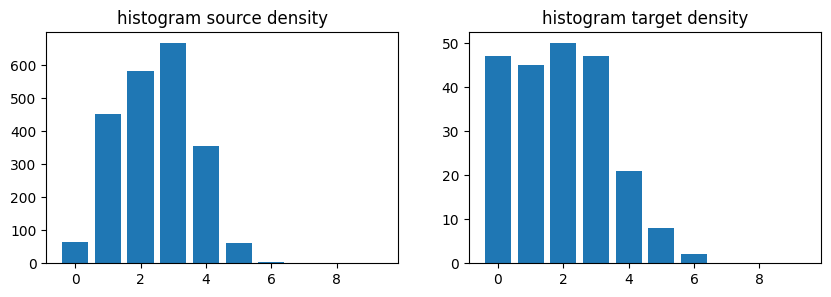

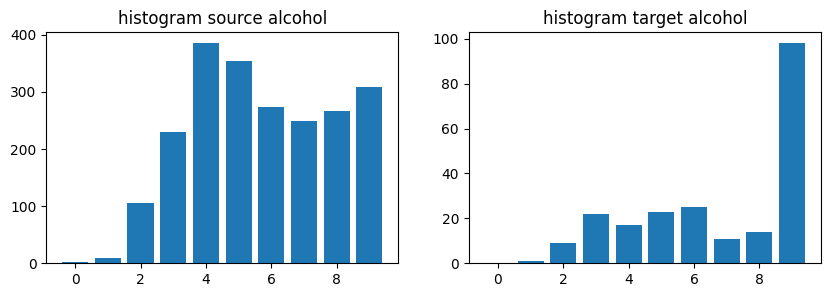

In [27]:
hist_dist_drift.plot_histograms_drifted_features(figsize=(10,3))

### Chi2Drift

Calculates drift using a chi-square test of independence of variable in a contingency table for each feature. It does the test separately for each variable.
This method is more appropriated for categorical features, but it can be used with the histograms as each bin could be considered as a category.

In this case, the `calculate_drift` method returns:

- scores: the chi2 stastistic for each variable.
- score: average of all the observed chi2 statistics.
- p_vals: p-value of each feature (returned by the tests)
- drift_detected: boolean indicating the decision if drift is detected. It depends on the selected p-value and the correction.
- threshold: the final threshold (to compare the p-values) applied after the correction is applied.

In [28]:
from mercury.monitoring.drift.chi2_drift_detector import Chi2Drift

chi2_drift = Chi2Drift(
    distr_src=histograms_train, distr_target=histograms_t1, correction="bonferroni", p_val=0.01
)

drift_metrics = chi2_drift.calculate_drift()
print("Drift Score: ", drift_metrics["score"])
print("Is drift detected? ", drift_metrics["drift_detected"])

Drift Score:  6.9737372
Is drift detected?  False


We can see that drift is not detected in this case.

In [29]:
from mercury.monitoring.drift.chi2_drift_detector import Chi2Drift

chi2_drift = Chi2Drift(
    distr_src=histograms_train, distr_target=histograms_t6, features=features, correction="bonferroni", p_val=0.01
)

drift_metrics = chi2_drift.calculate_drift()
print("Drift Score: ", drift_metrics["score"])
print("is drift detected? ", drift_metrics["drift_detected"])

Drift Score:  34.713696
is drift detected?  True


In this case, the drift score is increased and there is drift.

<a id="drift_predictions"></a>
# 7. Drift Detection - Model predictions

We can also look at the model predictions instead of the features. In this case, we need to obtain the predictions and specify them when creating the drift object. To show an example, we will use a method using the data samples (predicted probabilities) and a method using the histograms (histograms of predicted probabilities). 

We will compare if there is drift in the predictions obtained at timestep 1 with two posterior times: timestep 1 and timestep 7. 

Let's start obtaining the predictions at each required time and generating the histograms:

In [30]:
# Obtain predictions 
y_t1 = df_new[df_new["time"] == 1]["pred_prob"].values.copy()
y_t2 = df_new[df_new["time"] == 2]["pred_prob"].values.copy()
y_t7 = df_new[df_new["time"] == 7]["pred_prob"].values.copy()
y_t1 = np.expand_dims(y_t1, axis=1)
y_t2 = np.expand_dims(y_t2, axis=1)
y_t7 = np.expand_dims(y_t7, axis=1)

# Generate histograms
y_histogram_generator = HistogramGenerator(n_bins=10).fit(y_t1)
y_histograms_t1 = y_histogram_generator.get_histograms(y_t1)
y_histograms_t2 = y_histogram_generator.get_histograms(y_t2)
y_histograms_t7 = y_histogram_generator.get_histograms(y_t7)

<b> KS Drift </b>

Let's first use the KSDrift. In this case, we need to specify the data samples (predicted values):

In [31]:
# KS drift
ks_drift = KSDrift(y_t1, y_t2, features=["pred"], p_val=0.01, correction="bonferroni")
drift_metrics = ks_drift.calculate_drift()
print("Drift detected at time 2:", drift_metrics['drift_detected'])

ks_drift = KSDrift(y_t1, y_t7, features=["pred"], p_val=0.01, correction="bonferroni")
drift_metrics = ks_drift.calculate_drift()
print("Drift detected at time 7:", drift_metrics['drift_detected'])


Drift detected at time 2: False
Drift detected at time 7: True


We can check that drift is detected at time 7. Let's look at the distribution of the prediction at this timestep: 

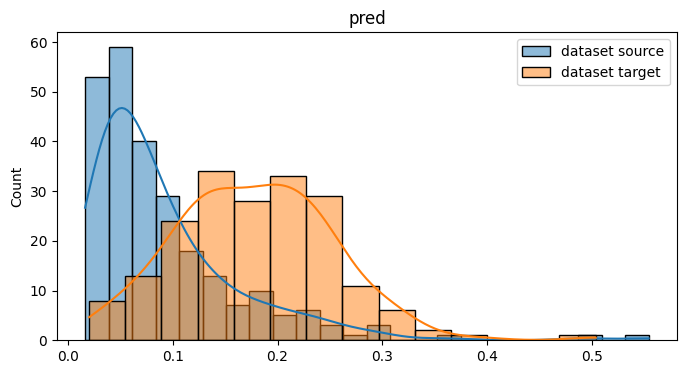

In [32]:
ks_drift.plot_distribution_drifted_features()

<b> Hellinger distance Drift </b>

Now let's use the HistogramDistanceDrift with the Hellinger distance metric. In this case, we specify the histograms of the predictions:

In [33]:
# Histogram distance - Hellinger
hellinger_dist_drift = HistogramDistanceDrift(
        distr_src=y_histograms_t1, distr_target=y_histograms_t2, features=["predictions"],
        distance_metric="hellinger", correction="bonferroni", p_val=0.01, n_permutations=50
    )
drift_metrics = hellinger_dist_drift.calculate_drift()
print("Drift detected at time 2:", drift_metrics['drift_detected'])

hellinger_dist_drift = HistogramDistanceDrift(
        distr_src=y_histograms_t1, distr_target=y_histograms_t7, features=["predictions"],
        distance_metric="hellinger", correction="bonferroni", p_val=0.01, n_permutations=50
    )
drift_metrics = hellinger_dist_drift.calculate_drift()
print("Drift detected at time 7:", drift_metrics['drift_detected'])

Drift detected at time 2: False
Drift detected at time 7: True


The result is the same as with the KSDrift. We can plot the histograms of the predictions:

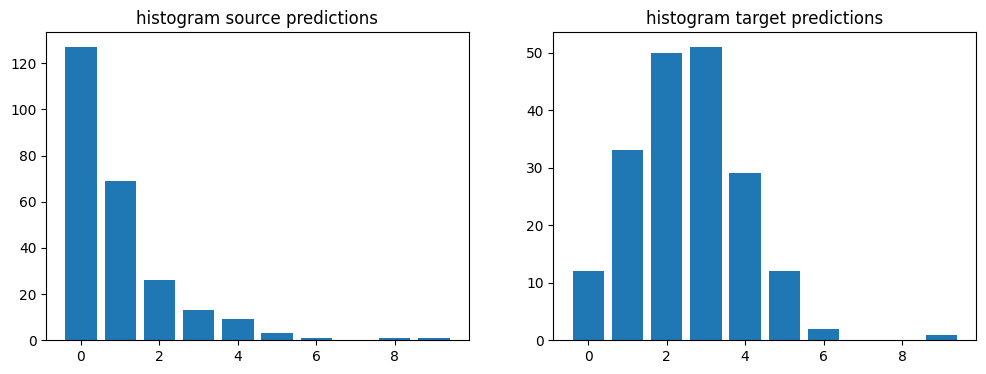

In [34]:
hellinger_dist_drift.plot_histograms_drifted_features(figsize=(12,4))

<a id="drift_evolution"></a>
# 8. Drift Evolution over time

Finally, we show an example of how we could analyze the drift over time. We can use the drift score given by a particular drift detector to analyze how the drift increases or decreases in the data over time.

Here we show an example using the KSDrift:


In [35]:
# Obtain initial dataset
X_src = X_initial.copy()

drift_scores = []

for t in range(7):
    # Obtain data for that timestep
    X_t = df[df["time"] == t][features].values.copy()
    # Create Drift Object and calculate drift
    ks_drift = KSDrift(X_src, X_t, features=features, p_val=0.01, correction="bonferroni")
    drift_metrics = ks_drift.calculate_drift()
    drift_scores.append(drift_metrics["score"])

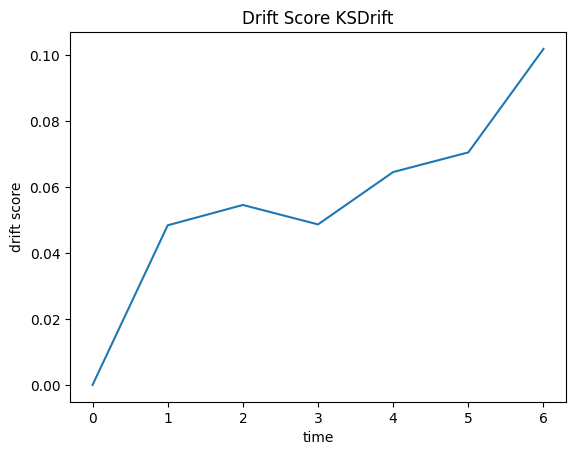

In [36]:
plt.plot(range(7), drift_scores)
plt.xlabel("time")
plt.ylabel("drift score")
title = plt.title("Drift Score KSDrift")

We can see how the Drift Score generally increases over time, as more wines with a higher level of alcohol are added.

# 8. Conclusions

In this notebook, we've shown how we can use the different drift methods to calculate the drift in the data. We've distinguished two main scenarios which require the use of different drift detectors:

- Scenario 1: Datasets are available. Use KSDrift or DomainClassifier Drift
- Scenario 2: Datasets are not available. Histograms can be used. Use HistogramDistanceDrift or Chi2Drift

# References

<a id="[1]">[1]</a> 
P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis.
Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.